In [1]:
import os
import tarfile
from pathlib import Path
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16, InceptionV3, DenseNet201, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [2]:
# Step 2: Load images and labels
def load_images_and_labels(base_path):
    images = []
    labels = []
    for fold in ['FOLD 1', 'FOLD 2', 'FOLD 3']:
        fold_path = Path(base_path) / fold
        for label in ['He', 'Hbv', 'Le', 'IPCL']:
            class_path = fold_path / label
            for img_path in class_path.glob('*.png'):
                img = cv2.imread(str(img_path))
                img = cv2.resize(img, (100, 100))  # Resize if necessary
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [3]:
images, labels = load_images_and_labels("laryngeal dataset")
label_names = ['He', 'Hbv', 'Le', 'IPCL']

In [4]:
# Step 3: Apply Gaussian filter
def apply_gaussian_filter(images, kernel_size=(5, 5), sigma=0.9):
    filtered_images = []
    for img in images:
        # Ensure the image is in grayscale
        # if len(img.shape) == 3:
        #     image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # else:
        image = img  # If already in grayscale, use as is

        # # Step 1: Contrast Adjustment
        # equalized_image = cv2.equalizeHist(image)

        # Step 2: Noise Reduction (Median Filter)
        median_filtered_image = cv2.medianBlur(image, 5)


        filtered_img = cv2.GaussianBlur(median_filtered_image, kernel_size, sigma)

        filtered_images.append(filtered_img)
    return np.array(filtered_images)

In [5]:
# Function to display sample images
def display_sample_images(images, labels, label_names, title, num_samples=5):
    fig, axes = plt.subplots(len(label_names), num_samples, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    for i, label_name in enumerate(label_names):
        label_indices = np.where(labels == label_name)[0]
        for j in range(num_samples):
            if j < len(label_indices):
                img_index = label_indices[j]
                axes[i, j].imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
        axes[i, 0].set_ylabel(label_name, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

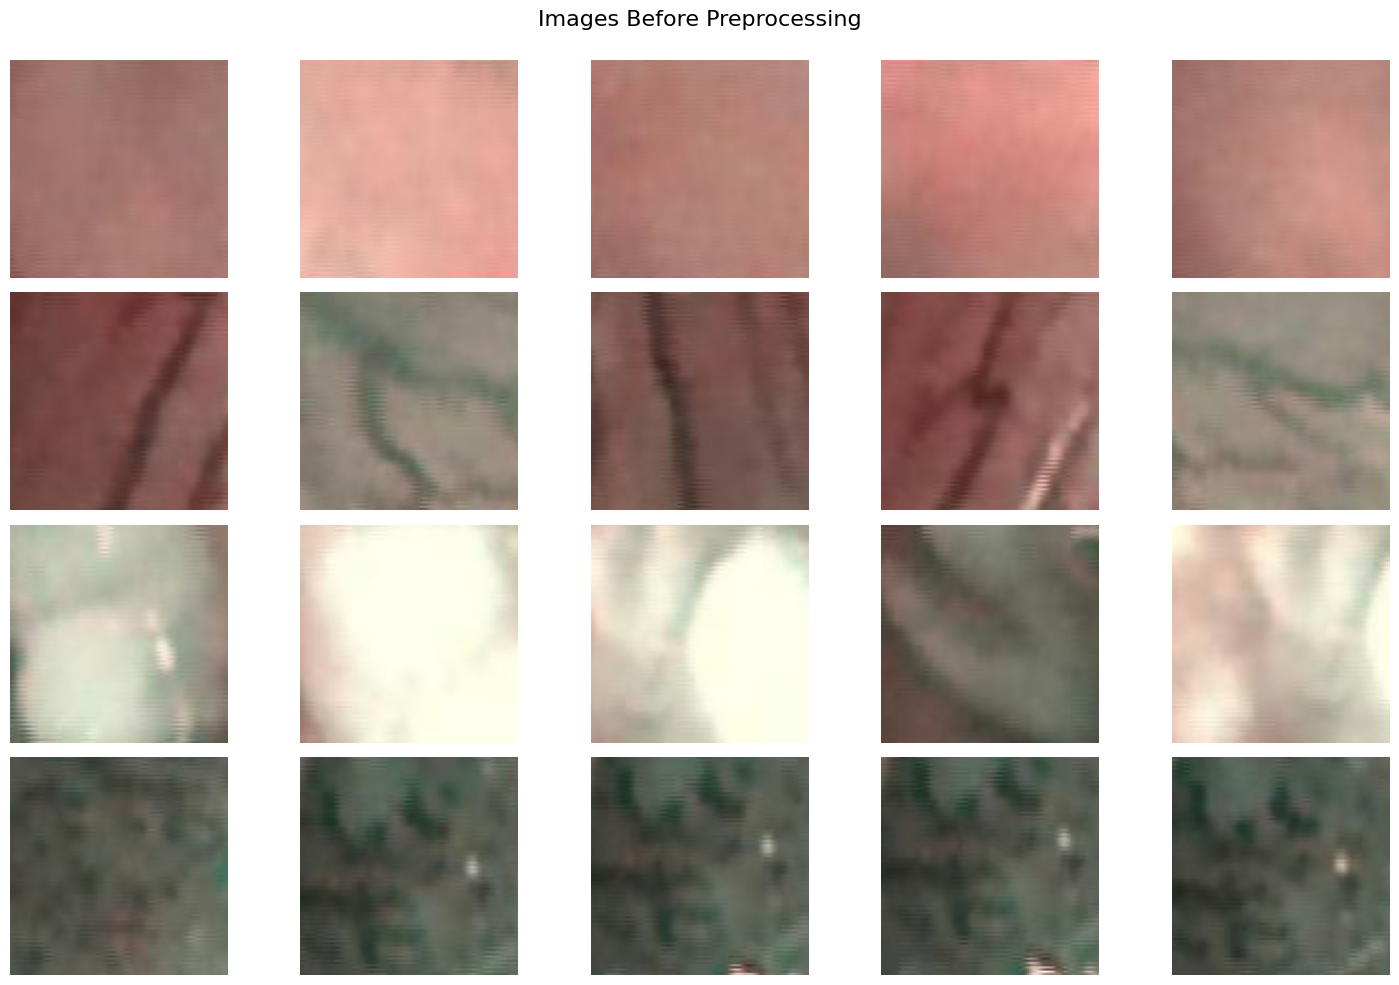

In [6]:
# Display images before preprocessing
display_sample_images(images, labels, label_names, "Images Before Preprocessing")

In [7]:
# Apply Gaussian filter
images_filtered = apply_gaussian_filter(images)

In [8]:
# Step 4: Preprocess images
images_vgg = preprocess_vgg(images_filtered.copy())
images_inception = preprocess_inception(images_filtered.copy())
images_densenet = preprocess_densenet(images_filtered.copy())
images_efficientnet = preprocess_efficientnet(images_filtered.copy())

In [9]:
# Step 5: Feature Extraction
def extract_features(model, images):
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

vgg_model = VGG16(include_top=False, input_shape=(100, 100, 3))
inception_model = InceptionV3(include_top=False, input_shape=(100, 100, 3))
densenet_model = DenseNet201(include_top=False, input_shape=(100, 100, 3))
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(100, 100, 3))

features_vgg = extract_features(vgg_model, images_vgg)
features_inception = extract_features(inception_model, images_inception)
features_densenet = extract_features(densenet_model, images_densenet)
features_efficientnet = extract_features(efficientnet_model, images_efficientnet)

# Combine features
features = np.hstack([features_vgg, features_vgg, features_densenet, features_efficientnet])

42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 605ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 541ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step


In [10]:
# Step 6: Encode labels
label_encoder = LabelEncoder()
labels_encoded1 = label_encoder.fit_transform(labels)

In [11]:
# Step 7: Split the data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(features,  labels_encoded1, test_size=0.2, random_state=42)

# Normalize the input data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Ensure that the shape of the arrays is as expected
print("X_train shape after normalization:", X_train.shape)
print("X_test shape after normalization:", X_test.shape)

X_train shape after normalization: (1056, 46976)
X_test shape after normalization: (264, 46976)


In [12]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score


# Initialize the base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Train the base models
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Get predictions from base models
rf_preds = rf.predict_proba(X_train)
svm_preds = svm.predict_proba(X_train)
knn_preds = knn.predict_proba(X_train)

# Stack predictions as new features
stacked_features_train = np.hstack((rf_preds, svm_preds, knn_preds))

# Do the same for the test set
rf_preds_test = rf.predict_proba(X_test)
svm_preds_test = svm.predict_proba(X_test)
knn_preds_test = knn.predict_proba(X_test)

stacked_features_test = np.hstack((rf_preds_test, svm_preds_test, knn_preds_test))

Stacking Classifier (Meta-learner) accuracy: 0.9924242424242424
Classification Report:
              precision    recall  f1-score   support

          He       1.00      0.97      0.98        61
         Hbv       0.98      1.00      0.99        64
          Le       0.99      1.00      0.99        70
        IPCL       1.00      1.00      1.00        69

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264



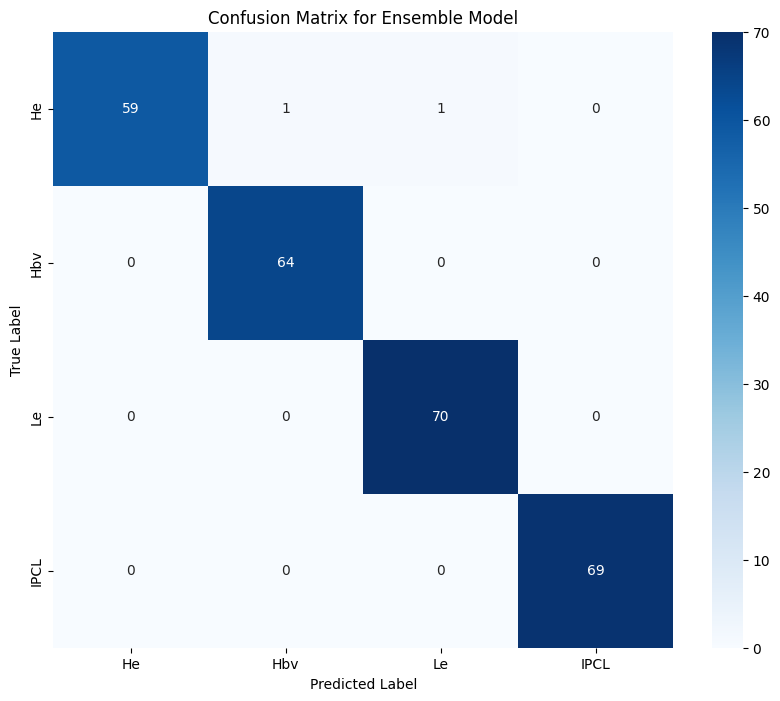

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Initialize the meta-classifier
meta_clf = LogisticRegression(random_state=42)

# Train the meta-classifier on the stacked features
meta_clf.fit(stacked_features_train, y_train)

# Predict with the meta-classifier
meta_preds = meta_clf.predict(stacked_features_test)

# Evaluate the meta-classifier
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f'Stacking Classifier (Meta-learner) accuracy: {meta_accuracy}')


conf_matrix = confusion_matrix(y_test, meta_preds)

classification_summary = classification_report(y_test, meta_preds, target_names=label_names)
print(f'Classification Report:\n{classification_summary}')


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()